In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('MachineLearning') \
    .master('local[*]') \
    .getOrCreate()

In [2]:
input_path = '/home/jovyan/work/data/'
users_path = f'{input_path}cleaned_data_users/'

In [397]:
df = spark.read.csv(users_path, multiLine=True, header=True, inferSchema=True)

In [398]:
print(f'Dataframe rows number: {df.count()}')

Dataframe rows number: 147577


In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [399]:
cols = ['_AccountId', 'forum', 'ActivityDays', 
        'comments_number', 'edits_of_answers', 'edits_of_question', 'created_questions', 
        'comments_every_day', 'activity_answer_edits', 'activity_question_edits', 'activity_questions']

In [400]:
df = df[cols]

In [401]:
df.printSchema()

root
 |-- _AccountId: integer (nullable = true)
 |-- forum: string (nullable = true)
 |-- ActivityDays: double (nullable = true)
 |-- comments_number: double (nullable = true)
 |-- edits_of_answers: double (nullable = true)
 |-- edits_of_question: double (nullable = true)
 |-- created_questions: double (nullable = true)
 |-- comments_every_day: double (nullable = true)
 |-- activity_answer_edits: double (nullable = true)
 |-- activity_question_edits: double (nullable = true)
 |-- activity_questions: double (nullable = true)



'OneHotEncoder'

In [402]:
str_cols = ['forum']
encoder = OneHotEncoder(inputCol='forum', outputCol='forum_features')

In [758]:
# unique list of forums
forums_list = df.select('forum').distinct().rdd.map(lambda r: r[0]).collect()
#forums_list

In [404]:
forum_udf = udf(lambda x: 1 if x == forum else 0)

In [405]:
for forum in forums_list:
    forum_udf = udf(lambda x: 1 if x == forum else 0)
    df = df.withColumn(f'forum_{forum}', forum_udf('forum'))
    df = df.withColumn(f'activity_days_{forum}', forum_udf('forum'))
    df = df.withColumn(f'comments_number_{forum}', forum_udf('forum'))
    df = df.withColumn(f'answer_edits_{forum}', forum_udf('forum'))
    df = df.withColumn(f'question_edits_{forum}', forum_udf('forum'))
    df = df.withColumn(f'created_questions_{forum}', forum_udf('forum'))
    df = df.withColumn(f'activity_comments_{forum}', forum_udf('forum'))
    df = df.withColumn(f'activity_answer_edits_{forum}', forum_udf('forum'))
    df = df.withColumn(f'activity_question_edits_{forum}', forum_udf('forum'))
    df = df.withColumn(f'activity_questions_{forum}', forum_udf('forum'))

In [406]:
exprs = {x: 'sum' for x in df.columns if x not in cols}

In [407]:
ddf=df.groupBy('_AccountId').agg(exprs)

In [408]:
# number of columns
len(ddf.columns)

81

Features

In [133]:
from pyspark.ml.feature import VectorAssembler

In [410]:
features = [col for col in ddf.columns if col != '_AccountId']

In [411]:
vector_assembler = VectorAssembler(inputCols = features, outputCol= "features_output")
data_training_and_test = vector_assembler.transform(ddf)

Normalization

In [412]:
from pyspark.ml.feature import Normalizer

In [413]:
normalizer = Normalizer(p=1, inputCol="features_output", outputCol="features_norm")

In [414]:
data_training_and_test = normalizer.transform(data_training_and_test)

#### Train and Test Data

In [432]:
(training_data, test_data) = data_training_and_test.randomSplit([0.7, 0.3])

### Modeling Fitting and Tunning
#### Grid Search - Finding the best parameters

In [415]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import *
from pyspark.ml.feature import PCA

In [416]:
very_small_sample = data_training_and_test.sample(False, 0.001).cache()
very_small_sample.count()

140

Dimension Reduction/feature selection

In [417]:
pca_model = PCA(inputCol = "features_norm", outputCol = "pca_features_cv_norm")
km = KMeans(seed=1, featuresCol="pca_features_cv_norm")
ppl_cv = Pipeline(stages = [pca_model, km])

In [418]:
ddf_length = len(ddf.columns)
from builtins import round as base_round
pca_nums = [base_round(i*ddf_length, 0) for i in [0.3, 0.5, 0.75]]
pca_nums

[24.0, 40.0, 61.0]

In [427]:
paramGrid = ParamGridBuilder() \
      .addGrid(pca_model.k, pca_nums) \
      .addGrid(km.k, [5, 8, 10]) \
      .build()

In [429]:
crossval = CrossValidator(estimator = ppl_cv, 
                          estimatorParamMaps=paramGrid,
                          evaluator = ClusteringEvaluator(featuresCol='pca_features_cv_norm', predictionCol='prediction'),
                          numFolds=4)

In [430]:
cv_model = crossval.fit(very_small_sample)

In [433]:
cv_predictions = cv_model.transform(test_data)
evaluator = ClusteringEvaluator(featuresCol='pca_features_cv_norm', predictionCol='prediction')
accuracy = evaluator.evaluate(cv_predictions)
accuracy

0.9338317823288612

In [434]:
cv_model.avgMetrics

[0.680244805460872,
 0.8825390597751505,
 0.8789360711909354,
 0.7235465042690128,
 0.8825390597751505,
 0.8721687266933276,
 0.7006112809685898,
 0.8838346891214681,
 0.8789360711909354]

##### Best model parameters

In [440]:
best_model = cv_model.bestModel
print(f'PCA parameters:\n'
      f'{best_model.stages[0]}')
print(f'KMeans parameters:\n'
      f'{best_model.stages[1]}')

PCA parameters:
PCAModel: uid=PCA_d568cc7898b3, k=61
KMeans parameters:
KMeansModel: uid=KMeans_8f47fa9e8b2f, k=8, distanceMeasure=euclidean, numFeatures=61


In [444]:
kmeans_num = best_model.stages[1].getK()
pca_num = best_model.stages[0].getK()

Modeling fitting and tuning

In [485]:
pca_model = PCA(k=pca_num, inputCol = "features_norm", outputCol = "pca_features_norm")
tuned_model = KMeans(k=kmeans_num, seed=1, featuresCol="pca_features_norm")
tuned_ppl = Pipeline(stages = [pca_model, tuned_model])

In [498]:
tuned_ppl = tuned_ppl.fit(training_data) # tuned_ppl - PipelineModel

In [499]:
trained_data = tuned_ppl.transform(data_training_and_test) # transformujemy nasze dane, zeby otrzymac wektor cech

In [452]:
centers = tuned_ppl.stages[1].clusterCenters()
len(centers)

8

In [457]:
train_predictions = tuned_ppl.transform(training_data)
evaluator = ClusteringEvaluator(featuresCol='pca_features_norm', predictionCol='prediction')
train_accuracy = evaluator.evaluate(train_predictions)
train_accuracy

0.9318446689509495

#### Evaluation
Evaluator for Clustering results, which expects two input columns: prediction and features. The metric computes the Silhouette measure using the squared Euclidean distance.

The Silhouette is a measure for the validation of the consistency within clusters. It ranges between 1 and -1, where a value close to 1 means that the points in a cluster are close to the other points in the same cluster and far from the points of the other clusters.

In [455]:
predictions = tuned_ppl.transform(test_data)
evaluator = ClusteringEvaluator(featuresCol='pca_features_norm', predictionCol='prediction')
test_accuracy = evaluator.evaluate(predictions)
test_accuracy

0.9337305689924346

### Save and Load Model

In [458]:
tuned_ppl.write().overwrite().save(input_path+'fitted_model')

In [459]:
from pyspark.ml import PipelineModel
mm=PipelineModel.load(input_path+'fitted_model')

In [518]:
cluster_centers = mm.stages[1].clusterCenters()

In [ ]:
# function to compare cluster centers to real data vectors
#from pyspark.ml.linalg import Vectors
#centroid = Vectors.dense(cluster_centers[0])
#centroid
#udf definition    
#def calc_centers(app, app_list):
#    if app == app_list:
#        return 1
#    else:
#        return 0
#def calc_centersUDF(app_list):
#    return udf(lambda l: calc_centers(l, app_list))
#trained_data = trained_data.withColumn('test', calc_centersUDF(centroid)(col('pca_features_norm')))
#trained_data.count()
#trained_data['pca_features_norm', 'test'].show(100, truncate=False)
#trained_data['_AccountId', 'test'].filter(trained_data['test'] == 1).show()

Assign predictions to data

In [779]:
trained_data_to_join = trained_data['_AccountId', 'prediction']
df2 = df[cols]

In [777]:
df_clustered = df2.join(trained_data_to_join, on='_AccountId', how='left')

In [773]:
df_clustered['_AccountId', 'prediction', 'forum'].show()

+----------+----------+------------+
|_AccountId|prediction|       forum|
+----------+----------+------------+
|         9|         7|   mythology|
|      2002|         1|   chemistry|
|      6576|         1|   chemistry|
|     25515|         1|   chemistry|
|     27657|         7|     spanish|
|     30571|         5|     spanish|
|     31703|         7|     spanish|
|     34968|         0|      french|
|     40966|         7|      french|
|     41985|         7|     italian|
|     49182|         2|windowsphone|
|     52519|         0|      french|
|     52720|         5|     spanish|
|     54600|         2|windowsphone|
|     59022|         5|     spanish|
|     60109|         2|windowsphone|
|     66654|         1|   chemistry|
|     75047|         1|   chemistry|
|     80650|         7|  portuguese|
|     85936|         5|     spanish|
+----------+----------+------------+
only showing top 20 rows



In [782]:
# dane z predykcjami dt. klastrow
df_clustered.printSchema()

root
 |-- _AccountId: integer (nullable = true)
 |-- forum: string (nullable = true)
 |-- ActivityDays: double (nullable = true)
 |-- comments_number: double (nullable = true)
 |-- edits_of_answers: double (nullable = true)
 |-- edits_of_question: double (nullable = true)
 |-- created_questions: double (nullable = true)
 |-- comments_every_day: double (nullable = true)
 |-- activity_answer_edits: double (nullable = true)
 |-- activity_question_edits: double (nullable = true)
 |-- activity_questions: double (nullable = true)
 |-- prediction: integer (nullable = true)



In [783]:
df_clustered.write.csv(path=input_path+'clustered_data_users', mode='overwrite', header=True)

In [785]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters

In [ ]:
sns.set_theme(style="white")

In [788]:
d=ddf['sum(forum_mythology)',
'sum(forum_french)',
 'sum(forum_chemistry)',
           'sum(forum_spanish)',
 'sum(forum_vegetarianism)',
 'sum(forum_portuguese)',
 'sum(forum_italian)', 'sum(forum_windowsphone)']

In [ ]:
expr = {}

In [ ]:
d.withColumnRenamed(expr)

In [791]:
d=d.toPandas()

<AxesSubplot:>

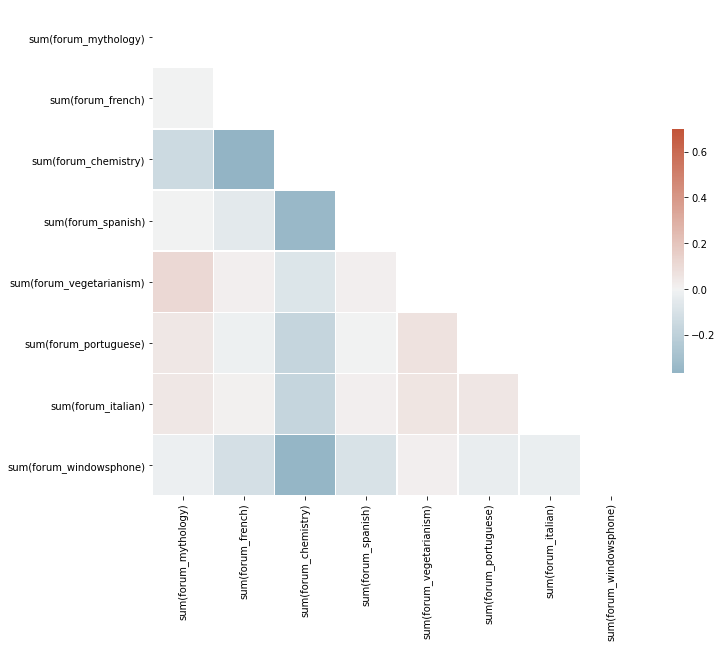

In [793]:
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
 #                columns=list(ascii_letters[26:]))
d
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
